# Lab 11 : Ising Model

## Objectives

In this lab we will look at a humorously (and disturbingly) bad random number generator that was used in practice.  We will also explore an example of Monte Carlo techniques through the study of the Ising model.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
#Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

rng = np.random.default_rng()

## Random Number Generators

You have been warned to never write your own random number generator. For a long time it has been recognized that the generation of random numbers by computers is a necessary feature, so system libraries provided with computers have contained functions for generating them.  Unfortunately this was not considered to be very important so these functions were not carefully created.  As an example we will consider the function `randu` which, many years ago, was provided on IBM mainframes in their system library.  Who knows how many people used this for what were suppose to be real simulations!  See [Wikipedia](http://en.wikipedia.org/wiki/RANDU) for an interesting, humorous, and disturbing discussion of this random number generator.  This is but one example.  It is because of these bad implementations that many people will still never use a random number generator provided in a system library.  More recently, due to the reliance on cryptography, quality random numbers have become very important, so very good, well tested random number generators are now commonly available.  Even so, `randu` remains as **the example** of how bad random number generators can be.

The details of the algorithm are not too important for our uses but it is good to see how/why things went wrong.  The function `randu` was a *linear congruential generator*.  The random sequence is generated as 
$$ I_{j+1} = (a I_j + c) \pmod m.$$
This is a perfectly good algorithm as long as $a$, $c$, and $m$ are chosen well.  The  choices made in the library were $m=2^{31}$, $a=65539$, and $c=0$ because the calculations could be implemented very efficiently, an important criterion at that time.  This is implemented as a Python class below. You should run this cell.

In [2]:
class badrand (object):
   """An implementation of a BAD random number generator.  This is based on
   randu() which appeared in the IBM library.  It should NEVER be used and
   will warn you to not use it!"""

   def __init__ (self, seed):
      """Initialize the random number generator.  You MUST provide a seed.
      This will warn you about using a bad random number generator."""
      self.seed = seed
      self.m = 1 << 31
      self.minv = 1.0 / self.m
      self.a = 65539
      self.c = 0
      print("""Congratulations, you just initialized a BAD random number generator.
You are now ready to NOT generate good random numbers.""")

   def ran(self, N):
      """Generate N random numbers in the interval [0,1).  This will warn
      you that you have bad random numbers."""
      res = np.zeros(N)
      for j in range(N):
         self.seed = (self.a * self.seed + self.c) % self.m
         res[j] = self.seed * self.minv
      print("""Bad random numbers generated.
You are not using these for anything serious, right?""")
      return res

To generate $N$ random numbers, you should use code similar to what follows. The name `randu` is arbitrary.  The seed must be a positive integer.  You must seed yourself. This is a bad random number generator so it is not suppose to be easy to use.  In fact, it will warn you that it is bad!
```
randu = badrand(seed)
# To get N random numbers we then use
br = randu.ran(N)
```

For our analysis we will use $N=300000$. Generate $N$ random numbers from a good random number generator, `rng.random` for example, and $N$ from the bad random number generator.  To see that `badrand` is not trivially bad, create a nice figure of a histogram of values generated for both sets of random numbers.  You should find that both appear nice and uniform as they should. (Note: When using `hist` you should probably plot the histograms as steps, not bars.  Also, the histograms may not appear to be too flat when you make them.  If so, check the range of values on the y-axis, ....)

Congratulations, you just initialized a BAD random number generator.
You are now ready to NOT generate good random numbers.
Bad random numbers generated.
You are not using these for anything serious, right?


(array([1.00120517, 1.00457186, 1.00143851, 0.99810516, 0.99890516,
        1.00263852, 1.0003385 , 1.00943855, 0.98983845, 0.9935718 ]),
 array([3.66405787e-06, 1.00003147e-01, 2.00002630e-01, 3.00002114e-01,
        4.00001597e-01, 5.00001080e-01, 6.00000563e-01, 7.00000046e-01,
        7.99999529e-01, 8.99999013e-01, 9.99998496e-01]),
 [<matplotlib.patches.Polygon at 0x218d1d9f0d0>])

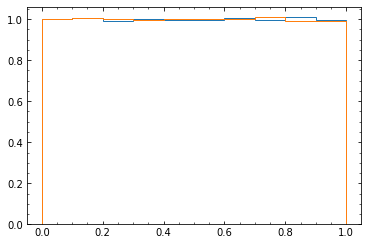

In [3]:
N=300000
seed=135246
randu = badrand(seed)
# To get N random numbers we then use
br = randu.ran(N)
plt.hist(br,histtype="step",density=True)
gr=rng.random(N)
plt.hist(gr,histtype="step",density=True)

The behavior looks perfectly sensible, so why not use this random number generator?  Let us jump to the problem: the random numbers are correlated.  To see this we want to arrange the random numbers we generated into triplets.  The easiest way to do this is to turn the 1 dimensional array into a 2 dimensional one with 3 columns.  This is trivial to do using `reshape` to, not surprisingly, reshape the array.  In fact, we want 3 columns and as many rows as required to use all the values.  Fortunately `reshape` can determine the number of row required for us!  Using `br = br.reshape((-1, 3))` does exactly what we want.  Call the first column of the reshaped array $x$, the second column $y$, and the third column $z$.  Finally define $i = 9x-6y+z$.

Calculate $i$ for both the good and bad random numbers.  Produce a nice figure showing $i$ versus $x$ for both sets of random numbers.  Using the period marker, ‘.’, for these plots is recommended.  Plot the good random numbers first.  You should find a mostly evenly sampled band.  Next plot the bad random numbers.  Be amazed!

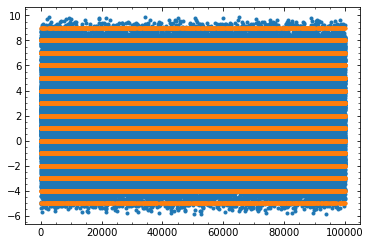

In [4]:
br=br.reshape((-1,3))
i_br=9*br[:,0]-6*br[:,1]+br[:,2]
gr=gr.reshape((-1,3))
i_gr=9*gr[:,0]-6*gr[:,1]+gr[:,2]
plt.plot(i_gr, ".")
plt.plot(i_br,".")

## Ising Model

Now that we know to be careful when generating random numbers we can use them for Monte Carlo simulations of systems.  One example comes from the study of the Ising model. The Ising model provides a simple way of examining how magnetic systems behave - in particular ferromagnets - as well as other systems described by the same mathematics (such as some fluids or gasses). The basic idea is to model the behavior of the system as spins on a lattice where each spin can interact with its nearest neighboring spins.

Here we will work with such a lattice in two dimensions. The lattice in this case is simply a grid, or matrix, containing values of either +1 (spin up) or -1 (spin down). The lattice is represented symbolically using the variable $\sigma(i,j)$, where $i$ and $j$ label coordinates on the lattice (or equivalently, matrix components).

Physically, such systems prefer to have adjacent spins aligned.  This can be achieved by defining an energy function which is minimized when nearby spins have the same value. This principle of minimizing the energy is commonly applied to other physical systems and is a prevalent idea in physics.

For our simple model here the energy of the system will thus be determined by the coupling of a spin with its nearest neighbors.  We can go a step further and also model the lattice of spins in the presence of an external magnetic field represented by the parameter  $\mu$.  A spin in a magnetic field prefers to align with the direction of magnetic field; the misalignment of the spin and the magnetic field will come at the cost of higher energy in the system.  Putting these ideas together the energy of the system can be written as

$$ E = -J\sum_{i,j}\sigma(i, j)\left[\sigma(i+1, j) + \sigma(i-1, j) + \sigma(i, j+1) + \sigma(i,j-1)\right] - \mu \sum_{i,j} \sigma(i,j), $$

where $J \geq 0$ is the strength of interactions between spins (so for larger values of $J$, the more the spins will prefer to be aligned). Note that the energy will be lowest (most negative) when all spins have the same value and the same sign as $\mu$. Also note that, because this energy function relies on computing values of adjacent spins we will need to decide how to handle spins on the boundary of the lattice.  This will be discussed below.

The general procedure we will use to simulate this system is known as the "Metropolis algorithm". Given a starting lattice of spins, we choose a random point ($i$, $j$). Next we decide whether or not to flip the spin at this chosen point using the following algorithm:

- If flipping the spin would result in a decrease in total energy of the system,  $\Delta E = E_\curvearrowright - E_\oslash < 0$, flip the spin.
- If not, flip the spin with a probability $\mathrm{e}^{-\Delta E/T}$, where $T$ is the temperature of the system.

Here $E_\oslash$ represents the energy of the system when the spin is not flipped ($\oslash$ representing "not flipped", this is the energy of the system before we apply the Metropolis algorithm) and  $E_\curvearrowright$ represents the energy the system will have if a spin is flipped (using the symbol $\curvearrowright$ to represent "flipped").  The time evolution of the system is modeled by repeatedly applying the Metropolis algorithm to determine how the spins behave.

### Evolution

To study the evolution we first need to generate an initial lattice. In principle any lattice containing values $\pm 1$ can be used.  We will begin with a randomized lattice which corresponds to an unmagnetized material. We can represent an $N\times N$ lattice simply by using a 2-d array. 

Define a function `random_lattice(N, rng)` that accepts the parameter $N$ and a random number generator, and returns a square matrix filled with random values $\pm 1$. The *generator* from `numpy.random` contains a few methods for generating such a lattice.  The most obvious method to consider is `rng.integers`. Carefully read the documentation to see how the upper limit of the range is treated

Use the function you write to generate a random $50\times 50$ lattice.  Use `imshow` to produce a quick plot of this lattice.  (All subsequent plots in this lab can be quick plots.)

In [5]:
def random_lattice(N, rng):
# YOUR CODE HERE
raise NotImplementedError()

IndentationError: expected an indented block (Temp/ipykernel_13884/2659802354.py, line 3)

Write a simple test using `assert` to verify that all the values return by `random_lattice` are either +1 or -1.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In the Metropolis algorithm we pick a random point and decide whether or not to flip the spin based on the change in energy.  Thus we need to write a function to calculate $\Delta E$ given a spin flip at a point ($i_f$, $j_f$), for some choice of integers $i_f, j_f \in [0, N-1]$. At first glance this looks tedious; the energy defined above contains sums over the entire lattice.  However, since we are only considering flipping a single spin, all of them will remain the same *except* at the point being flipped.  This means that since we are interested in the change in the energy, not the energy itself, most of the terms in the sum will cancel and $\Delta E$ will be a much simpler expression than we may have feared.  To see this, notice that if we flip the spin at $(i_f, j_f)$ the terms which *will not cancel* in the energy are given by
\begin{align}
E^{\rm non-canceling}_\curvearrowright & = -J\sigma_\curvearrowright(i_f,j_f)\left[\sigma(i_f+1,j_f) + \sigma(i_f-1,j_f) + \sigma(i_f,j_f+1) + \sigma(i_f,j_f-1)\right] \\ 
 & {} - J\sigma(i_f+1,j_f)\sigma_\curvearrowright(i_f,j_f) - J\sigma(i_f-1,j_f)\sigma_\curvearrowright(i_f,j_f) - J\sigma(i_f,j_f+1)\sigma_\curvearrowright(i_f,j_f) \\
 & {} - J\sigma(i_f,j_f-1)\sigma_\curvearrowright(i_f,j_f) - \mu \sigma_\curvearrowright(i_f,j_f) \\
 &= -2J\sigma_\curvearrowright(i_f,j_f)\left[\sigma(i_f+1,j_f) + \sigma(i_f-1,j_f) + \sigma(i_f,j_f+1) + \sigma(i_f,j_f-1)\right] - \mu \sigma_\curvearrowright(i_f, j_f) \\
\end{align}

Similarly, if we do not flip the spin then the non-canceling terms in the non-flipping energy will be exactly the same as those given above if we just replace $\curvearrowright$ with $\oslash$. Finally, since flipping the spin is equivalent to multiplying by $-1$ this means that $\sigma_\curvearrowright = -\sigma_\oslash$ and the difference in energy between flipping and not flipping the spin at $(i_f,j_f)$ is
$$\Delta E \equiv E_\curvearrowright - E_\oslash = 4J\sigma_\oslash(i_f,j_f)\left[\sigma(i_f+1,j_f) + \sigma(i_f-1,j_f) + \sigma(i_f,j_f+1) + \sigma(i_f,j_f-1)\right] + 2\mu\sigma_\oslash(i_f,j_f) \,.$$
This is the quantity we need in the Metropolis algorithm to help determine whether or not to flip a spin when the energy would increase if the spin is flipped.

#### Boundary Conditions

We are not quite done, we need to know how the system behaves on the lattice boundaries. Since $i_f, j_f \in [0, N-1]$, how do we calculate $E$ when $i_f$ or $j_f$ are $0$ or $N-1$? To resolve this we employ periodic boundary conditions meaning that $\sigma(-1,j_f) = \sigma(N-1,j_f)$, $\sigma(N,j_f) = \sigma(0,j_f)$, $\sigma(i_f,-1) = \sigma(i_f,N-1)$, and $\sigma(i_f,N) = \sigma(i_f,0)$. One simple way to implement this is to use modular arithmetic on the index values which allows increasing numbers to "wrap around" in the way we need. In Python (and in many languages), the mod function is implemented using the `%` operator, so $a \pmod b$ = `a % b`. If you are unfamiliar with modular arithmetic, the [wikipedia page](http://en.wikipedia.org/wiki/Modular_arithmetic) should help you catch up. For our purposes, it will suffice to mod the index values of each spin in the lattice by $N$ after adding or subtracting `1` from them. You should verify that running `-1%N` will return `N-1`, and `N%N` will return `0`. (*Warning:* languages other than Python may behave differently when modding negative numbers!  In some such languages `-1%N` is equal to `-1`.  Since `N%N` is always `0` it is safe to add `N` to any expression before using modular arithmetic.  In other words, it is always safe to write `(i-1+N)%N` and this will work in languages that treat negative numbers differently than Python.)

Write a function that accepts a lattice, the parameters $J$ and $\mu$, and the index values of a point, $i_f$ and $j_f$; and returns $\Delta E$, as specified below.

(*Note:* This function can determine the value of $N$ since `lattice` knows its size (see what `lattice.shape` returns).

In [ ]:
def DeltaE(lattice, J, mu, i_f, j_f):
# YOUR CODE HERE
raise NotImplementedError()

In order to test this function, note that for $J = 1$ and $\mu = 0$, $\Delta E$ will always be $0$, $\pm 8$, or $\pm 16$.  Write a test using `assert` to verify that this is true by checking all values returned by `DeltaE`. (*Note:* Yes, using loops for this is fine.  Also, the pipe character, `|`, means "or" for Boolean comparisons)

#### Metropolis Algorithm

We are finally ready to implement the Metropolis algorithm as described above.  We will use this to evolve the system by repeatedly applying it to a random lattice.  Here we write a function that implements the algorithm.

Write a function that accepts a lattice, picks a random point in it, and flips the spin at that point according to the Metropolis algorithm. This means that if $\Delta E < 0$, then the transition is favored and the spin should be flipped at the given point. On the other hand, if $\Delta E > 0$, then the spin may or may not be flipped based on the probability $\exp(-\Delta E/T)$. Your function should accept the lattice and the model parameters $J$, $\mu$, and $T$.  We will write a function of the form given below.

This function changes `lattice` but does not return anything.  A function that changes one of its inputs is known as a *mutator method*.  We use functions like this when small changes are made to a potentially large input to avoid making copies of it.

To proceed we also need to understand the use of $\exp(-\Delta E/T)$ as a probability.  Note that $0 < \exp(-\Delta E/T) \leq 1$, so it can indeed represent a probability of flipping. When it is stated that the spin should flip with this probability, we mean that the spin should flip, eg, $100\times\exp(-\Delta E/T)$ percent of the time. If $\Delta E$ is zero then we would flip 100 percent of the time.  If $\Delta E$ is very large then we should very rarely flip.  One way to accomplish this is to generate a random number between $0$ and $1$; if this number is less than $\exp(-\Delta E/T)$, flip the spin, if it is not, then leave the spin unchanged.

Finally, flipping the spin in the lattice is quite simple, it just means multiplying the value in the lattice by negative one.

In [ ]:
def flip_point(lattice, J, mu, T, rng):
# YOUR CODE HERE
raise NotImplementedError()

#### Evolving the System

With all this set up we can now evolve a system.  A square lattice with $N=50$ lattice contains $2500$ spins. If we wish for the final state of the system to be representative of the system after a long period of time, we should attempt to flip each point enough times that a spin flip at one point in the lattice has sufficient time to affect spins at points well separated from it. To accomplish this we will attempt to flip each spin approximately $4N$ times on average.

Evolve an initially random lattice of spins by calling the `flip_point` function $4 N \times N^2 = 500000$ times on it. Here is a case where using a for loop is completely acceptable. Note that this can take a few seconds to run so you may want to try a smaller number of flips to debug any problems. Let $J=1$, $\mu=0$, and $T=3.5$. Provide a quick plot of the final state of the system using `imshow`.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

The above image should contain (a) distinct region(s) of the same spins, with some randomly flipped values scattered throughout. This should be somewhat expected as the system is attempting to make nearby spins have similar values. The image should also contain some small regions with dissimilar spins, something to be discussed below.

#### Changing $T$

So far the role of $T$ has not been discussed. As you may have guessed, this corresponds to the "temperature" of the system. A higher temperature will tend to disorder the system, resulting in more random fluctuations in the system - more spin flips. We will test this now.

For a high enough temperature, spins should frequently flip even if the spin flip will cause an increase in energy. The higher the temperature, the more disordered the system should become. Verify this is the case by evolving another random lattice now using $T=10$ (and keeping $J=1$ and $\mu=0$).  Again produce a quick plot of the final state of the system.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In the opposite extreme, very low temperature, the system should settle into a near-equilibrium state with regions of similar spins having well-defined borders and few or no random fluctuations. Verify this by running your code for $T=0.1$ again producing a quick plot of the final state of the system.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Optional Explorations

There are many, many other things that can be explored within the Ising model.  To not make the lab exceedingly long we will stop here.  However, if you are interested there are a few other natural things to consider.  **These steps are not required.**

Empty cells are provided for convenience, and will contain implementations in the solutions.

#### Role of $\mu$

So far we have only considered $\mu=0$.  This is equivalent to a system of spins at some temperature, such as a magnet sitting on a table.  As stated above, $\mu$ represents an external magnetic field and can be used to study spins in such a setting, for example a magnet placed in an external magnetic field.  We know that spins prefer to align with an external magnetic field.  This means if $\mu$ is positive then positive spins (shown in red in our plots) should be preferred.  Explore different choices for $T$ and $\mu$ and see how the system behaves.  For example, we saw above that for $T=10$ the system remain fairly disordered.  What happens if we include a non-zero $\mu$ for this temperature?

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

#### Animation

Though looking at the final state is nice, it is even better to watch the evolution of the system by animating the evolution.  This can be accomplished in Matplotlib relatively easily.  Well, relatively easily once we understand the basic structure.  We did not have time to use this feature this semester and will not go through the details here.  There are many examples online showing how to animate plots.  An example will be provided in the solutions for your amusement.

To actually create the animation I recommend you read about [Embedding Matplotlib Animations](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/) for added guidance. In particular, pay attention to the **second method** described.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Member Participation

See Lab00 for instructions on turning in labs.  We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab.  Again, see Lab00 for more details.  It is expected that you have read and understood those details.